Imports all the required libraries, mounts Google Drive, and reads the stock data and characteristics to be analyzed.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, add_dummy_feature
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
import sklearn.linear_model as slm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
try:
  data = pd.read_csv('/content/drive/My Drive/characteristics_anom1.csv')
except:
  try:
    data = pd.read_csv('/content/drive/My Drive/BUFN650/Group Project/characteristics_anom.csv')
  except Exception as e:
    print(e)

data['date'] = pd.to_datetime(data['date'], format='%m/%Y')
data = data.set_index(['permno', 'date'])
data.head()

,,re,size,value,prof,valprof,fscore,debtiss,repurch,nissa,accruals,...,rome,strev,ivol,betaarb,season,indrrev,ciss,price,age,shvol
permno,date,,,,,,,,,,,,,,,,,,,,,
10006,1972-07-01,0.028600,0.699925,0.649009,-0.773268,-0.441137,-1.057577,-1.191008,-0.443104,-2.053981,0.163833,...,0.738251,0.169149,-0.253520,-0.597934,-0.762987,-0.549901,-1.220848,1.117585,1.213013,0.524622
10102,1972-07-01,0.039757,0.538023,1.406381,-0.604513,0.939781,0.432276,-1.191008,-0.443104,0.827987,0.266576,...,1.094331,-0.677317,-0.658350,0.556359,-1.199386,-0.482659,-0.027322,-0.683487,1.213013,-0.411568
10145,1972-07-01,-0.062422,1.379123,1.073137,-0.641500,0.334379,0.432276,-1.191008,-0.443104,-0.480636,-0.022215,...,0.280873,-0.095248,0.235483,0.346043,0.557622,-0.108870,-0.970639,0.395970,1.213013,0.102147
10153,1972-07-01,-0.065600,0.186578,1.688356,-0.463498,1.385077,-0.339504,-1.191008,2.255521,-2.121410,-0.502607,...,0.937779,-1.223870,0.596222,0.776458,0.432121,-1.216393,0.660034,-1.280549,1.213013,0.177518
10161,1972-07-01,-0.048933,1.313967,0.667652,-1.170883,-0.898941,-1.057577,-1.191008,-0.443104,-0.195935,0.463731,...,0.627744,0.944583,-1.145348,-0.350934,-0.680270,0.721773,-0.579507,0.427603,1.213013,-0.645615


The following section defines the target variable to be predicted (y) using features (X).

In [ ]:
X_var_names = data.columns[1:]
y_var_name = data.columns[0]
print('X variables: ', X_var_names.values)
print('y variable: ', y_var_name)

X variables:  ['size' 'value' 'prof' 'valprof' 'fscore' 'debtiss' 'repurch' 'nissa'
 'accruals' 'growth' 'aturnover' 'gmargins' 'ep' 'cfp' 'noa' 'inv'
 'invcap' 'igrowth' 'sgrowth' 'lev' 'roaa' 'roea' 'sp' 'mom' 'indmom'
 'valmom' 'valmomprof' 'mom12' 'momrev' 'lrrev' 'valuem' 'nissm' 'roe'
 'rome' 'strev' 'ivol' 'betaarb' 'season' 'indrrev' 'ciss' 'price' 'age'
 'shvol']
y variable:  re


The following section splits the data into training and testing sets. The training sample starts before 2005, and the testing sample starts in 2005 and the years after. Then the shapes of each dataset are printed to verify the split and better understand the data's dimensions.

In [ ]:
# Split
train_data = data[data.index.get_level_values('date').year < 2005]
test_data = data[data.index.get_level_values('date').year >= 2005]

X_var_names = data.columns[1:]
y_var_name = data.columns[0]

print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)

X_train = scale(train_data[X_var_names])
y_train = train_data[y_var_name]
X_test = scale(test_data[X_var_names])
y_test = test_data[y_var_name]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Train Data Shape: (350780, 44)
Test Data Shape: (151856, 44)
X_train shape: (350780, 43)
y_train shape: (350780,)
X_test shape: (151856, 43)
y_test shape: (151856,)


The following section assesses the performance of various machine learning models. MSE and R^2 are then calculated and printed to measure average error and better understand the proportion of variance.
Next, each model is assessed to compare their performance to help determine which approach will be the most effective in forecasting excess stock returns. We start with the Ordinary Least Squares regression, then Ridge, Lasso, Elastic Net, Principal Component, and finally Neural Network regression. By utilizing the evaluate_model function for each we can efficiently assess each model. Also by evaluating both training and testing sets, we can better understand how each model generalizes unseen data.

In [ ]:
def evaluate_model(model, X, y, label):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"{label} - MSE: {mse:.4f}, R2: {r2:.4f}")

In [ ]:
#OLS
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)
evaluate_model(ols_model, X_train, y_train, 'OLS Train')
evaluate_model(ols_model, X_test, y_test, 'OLS Test')

#Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
evaluate_model(ridge_model, X_train, y_train, 'Ridge Train')
evaluate_model(ridge_model, X_test, y_test, 'Ridge Test')

# Lasso
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train, y_train)
evaluate_model(lasso_model, X_train, y_train, 'Lasso Train')
evaluate_model(lasso_model, X_test, y_test, 'Lasso Test')

# Elastic Net
elastic_net_model = ElasticNet(alpha=0.01, l1_ratio=0.5)
elastic_net_model.fit(X_train, y_train)
evaluate_model(elastic_net_model, X_train, y_train, 'Elastic Net Train')
evaluate_model(elastic_net_model, X_test, y_test, 'Elastic Net Test')

# PCR
pca = PCA()
pcr_model = make_pipeline(pca, LinearRegression())
pcr_model.fit(X_train, y_train)
evaluate_model(pcr_model, X_train, y_train, 'PCR Train')
evaluate_model(pcr_model, X_test, y_test, 'PCR Test')

# Neural Network
nn_model = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
nn_model.fit(X_train, y_train)
evaluate_model(nn_model, X_train, y_train, 'Neural Network Train')
evaluate_model(nn_model, X_test, y_test, 'Neural Network Test')

OLS Train - MSE: 0.0125, R2: 0.0065
OLS Test - MSE: 0.0103, R2: -0.0072
Ridge Train - MSE: 0.0125, R2: 0.0065
Ridge Test - MSE: 0.0103, R2: -0.0072
Lasso Train - MSE: 0.0126, R2: 0.0000
Lasso Test - MSE: 0.0102, R2: -0.0001
Elastic Net Train - MSE: 0.0126, R2: 0.0001
Elastic Net Test - MSE: 0.0102, R2: -0.0001
PCR Train - MSE: 0.0125, R2: 0.0065
PCR Test - MSE: 0.0103, R2: -0.0072
Neural Network Train - MSE: 0.0124, R2: 0.0143
Neural Network Test - MSE: 0.0104, R2: -0.0165


This section focuses on the Ordinary Least Squares model and examines the importance of the features based on their coefficients. This will help us understand which variables are most significant in predicting the target variable.

In [ ]:
#OLS
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)
evaluate_model(ols_model, X_train, y_train, 'OLS Train')
evaluate_model(ols_model, X_test, y_test, 'OLS Test')

ols_coef = ols_model.coef_
sorted_idx_ols = np.argsort(np.abs(ols_coef))[::-1]
print("Variable Importance for OLS:")
for idx in sorted_idx_ols:
    print(f"{X_var_names[idx]}: {ols_coef[idx]:.4f}")

OLS Train - MSE: 0.0125, R2: 0.0065
OLS Test - MSE: 0.0103, R2: -0.0072
Variable Importance for OLS:
indrrev: -0.0065
valuem: 0.0052
lev: -0.0049
mom: -0.0042
mom12: 0.0039
value: -0.0039
season: 0.0030
cfp: 0.0028
roaa: -0.0028
rome: 0.0026
sp: 0.0025
valmom: 0.0024
price: -0.0023
strev: 0.0020
age: -0.0020
valmomprof: 0.0018
aturnover: -0.0018
roea: 0.0017
roe: 0.0014
momrev: -0.0014
ep: -0.0013
nissm: -0.0011
ciss: -0.0011
inv: -0.0011
noa: 0.0011
indmom: 0.0008
debtiss: 0.0007
lrrev: -0.0007
size: -0.0007
betaarb: 0.0006
gmargins: 0.0006
invcap: 0.0006
growth: 0.0005
valprof: -0.0004
igrowth: -0.0003
accruals: -0.0003
nissa: 0.0003
shvol: 0.0003
prof: 0.0003
ivol: -0.0002
repurch: -0.0002
sgrowth: 0.0001
fscore: -0.0001


This section focuses on the Ridge regression model, and the regularization term (alpha) penalizes any large coefficients. This is useful because by shrinking the coefficients of less important variables towards zero, we can better highlight the more signficant ones.

In [ ]:
#Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
evaluate_model(ridge_model, X_train, y_train, 'Ridge Train')
evaluate_model(ridge_model, X_test, y_test, 'Ridge Test')

ridge_coef = ridge_model.coef_
sorted_idx_ridge = np.argsort(np.abs(ridge_coef))[::-1]
print("Variable Importance for Ridge Regression:")
for idx in sorted_idx_ridge:
    print(f"{X_var_names[idx]}: {ridge_coef[idx]:.4f}")

Ridge Train - MSE: 0.0125, R2: 0.0065
Ridge Test - MSE: 0.0103, R2: -0.0072
Variable Importance for Ridge Regression:
indrrev: -0.0065
valuem: 0.0052
lev: -0.0049
mom: -0.0042
mom12: 0.0039
value: -0.0039
season: 0.0030
cfp: 0.0028
roaa: -0.0028
rome: 0.0026
sp: 0.0025
valmom: 0.0024
price: -0.0023
strev: 0.0020
age: -0.0020
valmomprof: 0.0018
aturnover: -0.0018
roea: 0.0017
roe: 0.0014
momrev: -0.0014
ep: -0.0013
nissm: -0.0011
ciss: -0.0011
inv: -0.0011
noa: 0.0011
indmom: 0.0008
debtiss: 0.0007
lrrev: -0.0007
size: -0.0007
betaarb: 0.0006
gmargins: 0.0006
invcap: 0.0006
growth: 0.0005
valprof: -0.0004
igrowth: -0.0003
accruals: -0.0003
nissa: 0.0003
shvol: 0.0003
prof: 0.0003
ivol: -0.0002
repurch: -0.0002
sgrowth: 0.0001
fscore: -0.0001


This section focuses on the Lasso regression model, which is similar to the Ridge but differs in its ability to shrink some coefficients to exactly zero. This is useful in reducing the model's comlpexity and help prevent overfitting. Once again by shrinking the less useful coefficients to zero, we can better focus on the more useful ones to help our model's prediction.

In [ ]:
# Lasso
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train, y_train)
evaluate_model(lasso_model, X_train, y_train, 'Lasso Train')
evaluate_model(lasso_model, X_test, y_test, 'Lasso Test')

lasso_coef = lasso_model.coef_
sorted_idx_lasso = np.argsort(np.abs(lasso_coef))[::-1]
print("Variable Importance for Lasso:")
for idx in sorted_idx_lasso:
    print(f"{X_var_names[idx]}: {lasso_coef[idx]:.4f}")

Lasso Train - MSE: 0.0126, R2: 0.0000
Lasso Test - MSE: 0.0102, R2: -0.0001
Variable Importance for Lasso:
shvol: 0.0000
aturnover: 0.0000
sgrowth: -0.0000
igrowth: -0.0000
invcap: -0.0000
inv: -0.0000
noa: -0.0000
cfp: 0.0000
ep: 0.0000
gmargins: -0.0000
growth: -0.0000
roaa: -0.0000
accruals: -0.0000
nissa: -0.0000
repurch: 0.0000
debtiss: 0.0000
fscore: 0.0000
valprof: 0.0000
prof: 0.0000
value: 0.0000
lev: 0.0000
roea: -0.0000
age: -0.0000
roe: 0.0000
price: -0.0000
ciss: -0.0000
indrrev: -0.0000
season: 0.0000
betaarb: 0.0000
ivol: 0.0000
strev: -0.0000
rome: 0.0000
nissm: -0.0000
sp: 0.0000
valuem: 0.0000
lrrev: -0.0000
momrev: -0.0000
mom12: 0.0000
valmomprof: 0.0000
valmom: 0.0000
indmom: 0.0000
mom: 0.0000
size: -0.0000


This section focuses on the Elastic Net regression model, which takes properties from both the Ridge and Lasso models. It is able to select important features like Lasso, and shrink the highly correlated ones like Ridge in order to find the most important features.

In [ ]:
# Elastic Net
elastic_net_model = ElasticNet(alpha=0.01, l1_ratio=0.5)
elastic_net_model.fit(X_train, y_train)
evaluate_model(elastic_net_model, X_train, y_train, 'Elastic Net Train')
evaluate_model(elastic_net_model, X_test, y_test, 'Elastic Net Test')

elastic_net_coef = elastic_net_model.coef_
sorted_idx_elastic = np.argsort(np.abs(elastic_net_coef))[::-1]
print("Variable Importance for Elastic Net:")
for idx in sorted_idx_elastic:
    print(f"{X_var_names[idx]}: {elastic_net_coef[idx]:.4f}")

Elastic Net Train - MSE: 0.0126, R2: 0.0001
Elastic Net Test - MSE: 0.0102, R2: -0.0001
Variable Importance for Elastic Net:
indrrev: -0.0001
shvol: 0.0000
aturnover: 0.0000
sgrowth: -0.0000
igrowth: -0.0000
invcap: -0.0000
inv: -0.0000
noa: -0.0000
cfp: 0.0000
ep: 0.0000
gmargins: -0.0000
growth: -0.0000
roaa: -0.0000
accruals: -0.0000
nissa: -0.0000
repurch: 0.0000
debtiss: 0.0000
fscore: 0.0000
valprof: 0.0000
prof: 0.0000
value: 0.0000
lev: 0.0000
roea: -0.0000
age: -0.0000
sp: 0.0000
price: -0.0000
ciss: -0.0000
season: 0.0000
betaarb: 0.0000
ivol: 0.0000
strev: -0.0000
rome: 0.0000
roe: 0.0000
nissm: -0.0000
valuem: 0.0000
lrrev: -0.0000
momrev: -0.0000
mom12: 0.0000
valmomprof: 0.0000
valmom: 0.0000
indmom: 0.0000
mom: 0.0000
size: -0.0000


This section focuses on the Principal Component Regression model, which first applies principal component analysis to reduce the dimensionality of the data and then uses those principal components in a linear regression model. PCA is useful in reducing the features to a smaller set of uncorrelated components, and the first principal component can help us understand variance in the data and better determine which features are significant.

In [ ]:
# PCR
pca = PCA()
pcr_model = make_pipeline(pca, LinearRegression())
pcr_model.fit(X_train, y_train)
evaluate_model(pcr_model, X_train, y_train, 'PCR Train')
evaluate_model(pcr_model, X_test, y_test, 'PCR Test')

pca_components = pca.components_[0]
sorted_idx_pcr = np.argsort(np.abs(pca_components))[::-1]
print("Variable Importance for PCR:")
for idx in sorted_idx_pcr:
    print(f"{X_var_names[idx]}: {pca_components[idx]:.4f}")

PCR Train - MSE: 0.0125, R2: 0.0065
PCR Test - MSE: 0.0103, R2: -0.0072
Variable Importance for PCR:
value: -0.3220
lev: -0.3172
valuem: -0.2806
cfp: -0.2622
valmom: -0.2408
sp: -0.2266
roaa: 0.2234
invcap: 0.2108
roea: 0.2095
growth: 0.2009
lrrev: 0.1847
prof: 0.1787
sgrowth: 0.1709
gmargins: 0.1614
ep: -0.1528
noa: -0.1514
age: -0.1471
inv: 0.1429
betaarb: 0.1309
roe: 0.1289
ciss: 0.1113
rome: -0.1070
ivol: 0.1053
igrowth: 0.1048
valmomprof: -0.1012
valprof: -0.0973
accruals: 0.0960
shvol: 0.0953
debtiss: 0.0756
momrev: 0.0684
aturnover: 0.0621
season: 0.0597
nissa: 0.0577
repurch: -0.0554
mom: -0.0482
nissm: 0.0457
price: 0.0435
size: 0.0309
mom12: -0.0287
fscore: 0.0219
indmom: -0.0137
strev: -0.0037
indrrev: -0.0028


This section focuses on the neural network model, which is a type of multi-layer perceptron and form of a feed-forward network. Using this approach we sum the absolute weights of the first layer to get a rough estimate of each feature's importance. Our network has one hidden layer with 50 neurons and iterates 1000 times for training data.

In [ ]:
# Neural Network
nn_model = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
nn_model.fit(X_train, y_train)
evaluate_model(nn_model, X_train, y_train, 'Neural Network Train')
evaluate_model(nn_model, X_test, y_test, 'Neural Network Test')

nn_coefs = nn_model.coefs_[0]  # Considering weights of the first layer
sorted_idx_nn = np.argsort(np.abs(nn_coefs.sum(axis=1)))[::-1]
print("Variable Importance for Neural Network:")
for idx in sorted_idx_nn:
    print(f"{X_var_names[idx]}: {nn_coefs.sum(axis=1)[idx]:.4f}")

Neural Network Train - MSE: 0.0124, R2: 0.0143
Neural Network Test - MSE: 0.0104, R2: -0.0165
Variable Importance for Neural Network:
value: 1.2860
price: -1.2034
debtiss: -1.0953
ivol: 1.0300
roaa: 0.9587
valmom: -0.8813
inv: 0.8105
lrrev: 0.7614
strev: -0.7599
noa: 0.7116
growth: -0.6428
valprof: 0.6327
prof: -0.6196
season: 0.5968
gmargins: 0.5841
aturnover: 0.5524
betaarb: 0.5475
roe: 0.5334
indrrev: 0.5276
shvol: -0.5173
roea: -0.4908
rome: -0.4664
nissa: 0.4513
invcap: 0.4431
igrowth: -0.4382
ep: 0.4369
lev: -0.4251
valmomprof: 0.4235
ciss: 0.4229
age: 0.4109
mom12: -0.3836
indmom: -0.2669
valuem: 0.2499
repurch: 0.2498
nissm: -0.2415
accruals: -0.1998
mom: 0.1994
sgrowth: -0.1810
size: 0.1686
momrev: 0.1403
sp: -0.1065
fscore: 0.0426
cfp: -0.0224


The following section focuses on the Random Forest regression model, which is an ensemble learning method that operates by constructing decision trees during training and outputs the average prediction of the individual trees. Our model is set up to use 10 trees to train the model. The benefit of using a random forest is that it can take a large number of features with a lower chance of overfitting, and the feature importance scores are helpful in identifying which variables are driving the model's prediciton.

In [ ]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=10, random_state=20)
rf_model.fit(X_train, y_train)
evaluate_model(rf_model, X_train, y_train, 'Random Forest Train')
evaluate_model(rf_model, X_test, y_test, 'Random Forest Test')

feature_importances = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
print("Variable Importance:")
for idx in sorted_idx:
    print(f"{X_var_names[idx]}: {feature_importances[idx]:.4f}")

Random Forest Train - MSE: 0.0023, R2: 0.8192
Random Forest Test - MSE: 0.0167, R2: -0.6389
Variable Importance:
repurch: 0.0488
debtiss: 0.0459
season: 0.0314
ivol: 0.0296
momrev: 0.0292
betaarb: 0.0290
mom12: 0.0290
price: 0.0285
shvol: 0.0274
indmom: 0.0272
indrrev: 0.0268
age: 0.0266
strev: 0.0261
igrowth: 0.0255
fscore: 0.0247
accruals: 0.0247
lrrev: 0.0247
mom: 0.0238
rome: 0.0237
ciss: 0.0223
invcap: 0.0216
nissm: 0.0211
size: 0.0207
roe: 0.0207
sgrowth: 0.0202
gmargins: 0.0202
nissa: 0.0197
inv: 0.0193
growth: 0.0192
roaa: 0.0191
valmomprof: 0.0190
valmom: 0.0190
noa: 0.0188
cfp: 0.0185
valuem: 0.0181
valprof: 0.0178
aturnover: 0.0172
prof: 0.0171
ep: 0.0170
sp: 0.0166
roea: 0.0161
lev: 0.0147
value: 0.0132


### Eddie's Experimentations below!

In [ ]:
cols = data.columns[:]
ed_data = pd.DataFrame(data)
ed_data['increased'] = ed_data['re'].gt(ed_data['re'].shift()).astype(int)

train = ed_data[ed_data.index.get_level_values('date').year < 2005]
test = ed_data[ed_data.index.get_level_values('date').year >= 2005]

train_cols = train.columns[1:-1]
EX_train = scale(train[train_cols])
Ey_train = (train['increased'])
print(Ey_train)

EX_test = scale(test[train_cols])
Ey_test = (test['increased'])

permno  date      
10006   1972-07-01    0
10102   1972-07-01    1
10145   1972-07-01    0
10153   1972-07-01    0
10161   1972-07-01    1
                     ..
88867   2004-12-01    1
90756   2004-12-01    0
91380   2004-12-01    1
91556   2004-12-01    0
92073   2004-12-01    0
Name: increased, Length: 350780, dtype: int64


In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(EX_train, Ey_train)
print(r2_score(Ey_train, nb.predict(EX_train)))

-0.9348108630243941


In [ ]:
from sklearn.feature_selection import SelectKBest, r_regression
features = PolynomialFeatures(include_bias=False);
poly_train = features.fit_transform(data[data.index.get_level_values('date').year < 2005][data.columns[1:]])
poly_test = features.fit_transform(data[data.index.get_level_values('date').year >= 2005][data.columns[1:]])

X_poly = scale(SelectKBest(r_regression, k=50).fit_transform(poly_train, y_train))
X_test_poly = scale(SelectKBest(r_regression, k=50).fit_transform(poly_test, y_test))

In [ ]:
# Directly stolen from the PS answers. I'll fix it up later.
def plot_mse(model, alphas, X_train=X_train, X_test=X_test, y_train=y_train, modtype='Ridge'):
  # fit a model
  model.fit(X_train, y_train)

  # compute MSE as a function of alpha
  scores = []
  coefs = []
  for a in alphas:
      # set current alpha
      model.set_params(alpha=a)
      # save scores
      scores.append(-cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())
      # save coefs
      coefs.append(model.coef_)

  # plot MSE in the test data
  ax = plt.gca()
  ax.plot(alphas, scores)
  ax.set_xscale('log')
  plt.axis('tight')
  plt.xlabel('alpha')
  plt.ylabel('MSE')
  plt.grid()
  plt.title(f'{modtype} coefficients as a function of the regularization')

932.60334688322


Ridge(alpha=10000000.0)

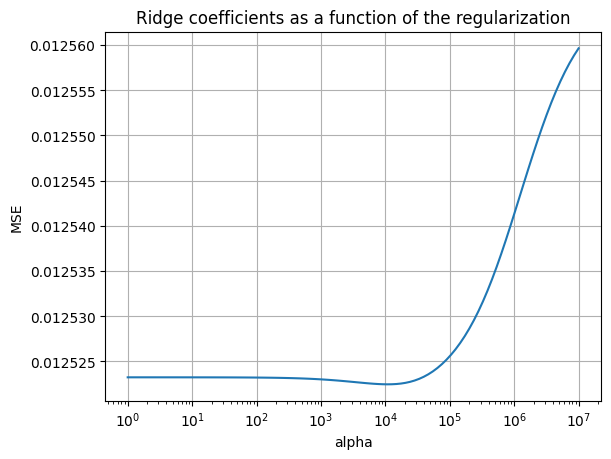

In [ ]:
alphas = 10**np.linspace(0,7,100)
ridge_CV = RidgeCV(alphas=alphas, fit_intercept=True)
ridge_CV.fit(X_poly, y_train)
print(ridge_CV.alpha_)

ridge = Ridge(fit_intercept=True, alpha=ridge_CV.alpha_)
plot_mse(ridge, alphas, X_train=X_poly, X_test=X_test_poly)
ridge.fit(X_poly, y_train)

#cv = ElasticNetCV(alphas=alphas, fit_intercept=True, max_iter=100000, cv=5, l1_ratio=np.linspace(.05, 1.0, 20))
#cv.fit(X_poly, y_train)
#print(r2_score(y_test, cv.predict(X_test_poly)))

In [ ]:
ridge.set_params(alpha=ridge_CV.alpha_)
print(r2_score(y_test, ridge_CV.predict(X_test_poly)))

-0.014989888805341023
